In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images

In [2]:
mode = 'CMS'
bias_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/' + mode
bias_stack = get_stacks(bias_folder, get_mean_img=True, get_var_img=True, num_imgs=0)[0]

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/CMS/calibrated_CMS_RS_dark_1us_-25C 2024-10-20 03_11_51.fits


In [9]:
defect_map_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Outlier Maps/CMS_combined_Outlier_binary_maskdark.fits'
defect_map = fits.getdata(defect_map_file)
defect_map = np.where(defect_map == 0, np.nan, 1)
mean_bias_frame = bias_stack['mean_img'] * defect_map
var_bias_frame = bias_stack['var_img'] * defect_map

In [14]:
print(np.nanmean(mean_bias_frame) - 100)
print(np.nanmean(var_bias_frame))

0.9001183900261367
158.3790969537313


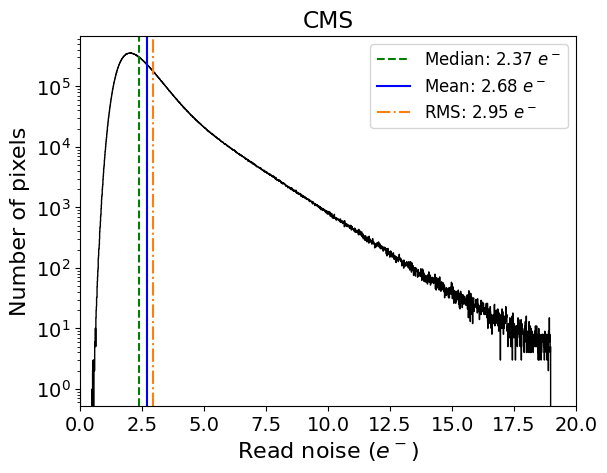

In [10]:
%matplotlib inline
gain = 4.27 # ADU/e-

read_noise_array = np.sqrt(var_bias_frame) / gain
read_noise_median = np.nanmedian(read_noise_array)
read_noise_mean = np.nanmean(read_noise_array)
plt.rcParams.update({'font.size': 14})
hist, bin_centers, bin_edges = plt.hist(read_noise_array.flatten(), bins=2000, range=(0, read_noise_median * 8), histtype='step', color='k')
plt.xlabel(r'Read noise ($e^-$)', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log')
read_noise_mode = bin_centers[np.argmax(hist)]
plt.axvline(read_noise_median, color='green', linestyle='--', label=f'Median: {read_noise_median:.2f} ' + r'$e^-$')
plt.axvline(read_noise_mean, color='blue', linestyle='-', label=f'Mean: {read_noise_mean:.2f} ' + r'$e^-$')
read_noise_rms = np.sqrt(np.nanmean(read_noise_array ** 2))
plt.axvline(read_noise_rms, color='C1', linestyle='-.', label=f'RMS: {read_noise_rms:.2f} ' + r'$e^-$')
plt.legend(fontsize=12)
plt.xlim(0, 20)
plt.title(mode)
plt.show()

Try to understand the read noise outside of the very low-light level regime.

In [5]:
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/' + mode + '/Calibrated'
stacks = get_stacks(data_folder, get_mean_img=True, get_var_img=True)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/CMS/Calibrated/calibrated_CMS_RS_dark_30000ms_15C 2024-10-19 02_58_51.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/CMS/Calibrated/calibrated_CMS_RS_dark_10000ms_15C 2024-10-19 02_55_16.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/CMS/Calibrated/calibrated_CMS_RS_dark_30000ms_5C 2024-10-19 01_10_24.fits


In [6]:
corrected_30s_15C_images = stacks[0]['imagestack']
corrected_10s_15C_images = stacks[1]['imagestack']
corrected_30s_5C_images = stacks[2]['imagestack']
mean_subtracted_30s_15C_frame = np.mean(corrected_30s_15C_images, axis=0)
var_30s_15C_frame = np.var(corrected_30s_15C_images, axis=0)
mean_subtracted_10s_15C_frame = np.mean(corrected_10s_15C_images, axis=0)
var_10s_15C_frame = np.var(corrected_10s_15C_images, axis=0)
mean_subtracted_30s_5C_frame = np.mean(corrected_30s_5C_images, axis=0)
var_30s_5C_frame = np.var(corrected_30s_5C_images, axis=0)
# print(np.median(mean_subtracted_30s_15C_frame) * 4.333, np.mean(var_30s_15C_frame), np.median(var_30s_15C_frame))
# print(np.median(mean_subtracted_10s_15C_frame) * 4.333, np.mean(var_10s_15C_frame), np.median(var_10s_15C_frame))
# print(np.median(mean_subtracted_30s_5C_frame) * 4.333, np.mean(var_30s_5C_frame), np.median(var_30s_5C_frame))

In [7]:
from scipy.optimize import curve_fit
def gaussian(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) + C

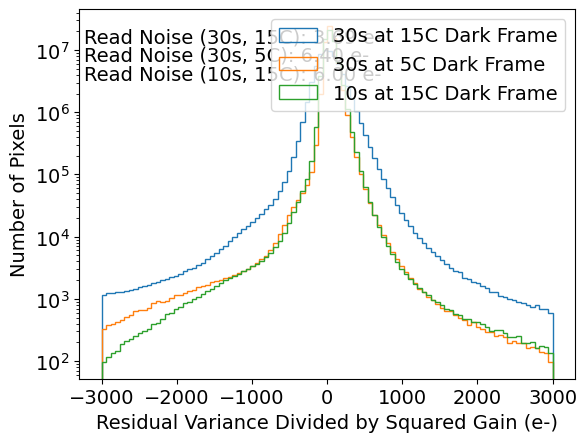

In [8]:
%matplotlib inline
sigma_temp_celcius = 0.001
gain_30s_15C = 4.0
gain_10s_15C = 4.0
gain_30s_5C = 4.0
temp_variance_factor = 6.6 ** 2 / sigma_temp_celcius ** 2
residual_variance_30s_15C_frame = var_30s_15C_frame - gain_30s_15C * mean_subtracted_30s_15C_frame - 1 / 12 - mean_subtracted_30s_5C_frame ** 2 / temp_variance_factor
residual_variance_30s_5C_frame = var_30s_5C_frame - gain_30s_5C * mean_subtracted_30s_5C_frame - 1 / 12 - mean_subtracted_30s_5C_frame ** 2 / temp_variance_factor
residual_variance_10s_15C_frame = var_10s_15C_frame - gain_10s_15C * mean_subtracted_10s_15C_frame - 1 / 12 - mean_subtracted_30s_5C_frame ** 2 / temp_variance_factor
residual_variance_30s_15C_frame /= gain_30s_15C ** 2
residual_variance_30s_5C_frame /= gain_30s_5C ** 2
residual_variance_10s_15C_frame /= gain_10s_15C ** 2
# print(np.nanmean(residual_variance_30s_15C_frame), np.nanmean(residual_variance_30s_5C_frame), np.nanmean(residual_variance_10s_15C_frame))
# print(np.nanmedian(residual_variance_30s_15C_frame), np.nanmedian(residual_variance_30s_5C_frame), np.nanmedian(residual_variance_10s_15C_frame))
read_noise_30s_15C = np.sqrt(np.nanmedian(residual_variance_30s_15C_frame))
read_noise_30s_5C = np.sqrt(np.nanmedian(residual_variance_30s_5C_frame))
read_noise_10s_15C = np.sqrt(np.nanmedian(residual_variance_10s_15C_frame))
hist1, bin_edges1, patches1  = plt.hist(residual_variance_30s_15C_frame.flatten(), bins=100, range=(-3000, 3000), histtype='step', label='30s at 15C Dark Frame')
hist2, bin_edges2, patches2 = plt.hist(residual_variance_30s_5C_frame[:,:].flatten(), bins=100, range=(-3000, 3000), histtype='step', label='30s at 5C Dark Frame')
hist3, bin_edges3, patches3 = plt.hist(residual_variance_10s_15C_frame.flatten(), bins=100, range=(-3000, 3000), histtype='step', label='10s at 15C Dark Frame')
# Fit Gaussians to histograms
# bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
# bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
# bin_centers3 = (bin_edges3[:-1] + bin_edges3[1:]) / 2
# popt1, pcov1 = curve_fit(gaussian, bin_centers1, hist1, p0=[1E7, 0, 500, 1000])
# popt2, pcov2 = curve_fit(gaussian, bin_centers2, hist2, p0=[1E7, 0, 500, 1000])
# popt3, pcov3 = curve_fit(gaussian, bin_centers3, hist3, p0=[1E7, 0, 500, 1000])
# print(np.sqrt(popt1[1]), np.sqrt(popt2)[1], np.sqrt(popt3[1]))
# Plot the fitted Gaussians
# plt.plot(bin_centers1, gaussian(bin_centers1, *popt1), 'r--', label='Fit to 15C Dark Frame')
# plt.plot(bin_centers2, gaussian(bin_centers2, *popt2), 'g--', label='Fit to 10C Dark Frame')
# Print medians
plt.text(0.01, 0.95, f'Read Noise (30s, 15C): {read_noise_30s_15C:.2f} e-', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.01, 0.9, f'Read Noise (30s, 5C): {read_noise_30s_5C:.2f} e-', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.01, 0.85, f'Read Noise (10s, 15C): {read_noise_10s_15C:.2f} e-', ha='left', va='top', transform=plt.gca().transAxes)
plt.xlabel('Residual Variance Divided by Squared Gain (e-)')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper right')
# Add gridlines
# plt.grid(True)
plt.show()